In [1]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install fastai==2.6.3 --no-deps
!pip install self_supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.9/197.9 kB 5.0 MB/s eta 0:00:0000:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.4
    Uninstalling fastai-2.7.4:
      Successfully uninstalled fastai-2.7.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 10.2 MB/s eta 0:00:00a 0:00:01


In [2]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [3]:
import fastai
import self_supervised
import torch
assert(fastai.__version__ == '2.6.3') #Check that version is 2.6.3

In [4]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")
#from Base_Stein.SVGD_classes import *

In [5]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))

In [6]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [7]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [8]:
#Uniform random number between a and b
def Unif(a,b):
    return (b-a)*torch.rand(1).item()+a

In [140]:
def random_polynomial(A):
    
    #B=torch.normal(mean=0, std=0.025, size=(1, 1)).item() #First Horner term (and is coefficient of x^4)
    
    #Btem = torch.normal(mean=0,std=0.05, size=(1, 1)).item() #Sample coefficient of x^3
    #B = Btem + B*A #Third Horner term
    
    B = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
    
#     Btem = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
#     B = Btem + B*A #Third Horner term
    
    Btem = random.choice([-1,1])*torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x
    #Btem=1
    B = Btem + B*A #Fourth Horner term
    
    Btem = torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x^0
    B = Btem + B*A #Fifth Horner term
    
    
    return B

In [141]:
def random_polynomial_bestsofar(A):
    
    
    B=torch.normal(mean=0, std=0.025, size=(1, 1)).item() #First Horner term (and is coefficient of x^4)
    
    Btem = torch.normal(mean=0,std=0.05, size=(1, 1)).item() #Sample coefficient of x^3
    B = Btem + B*A #Third Horner term
    
    Btem = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
    B = Btem + B*A #Third Horner term
    
    Btem = random.choice([-1,1])*torch.normal(mean=1,std=2, size=(1, 1)).item() #Sample coefficient of x
    B = Btem + B*A #Fourth Horner term
    
    Btem = torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x^0
    B = Btem + B*A #Fifth Horner term
    
    
    return B

In [142]:
def low_deg(A):
    power=Unif(1,1.25)
    coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
    coeff1 = torch.normal(mean=1, std=1, size=(1, 1)).item() #degree 2 term
    
#     coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
#     coeff1 = torch.normal(mean=1, std=0.7, size=(1, 1)).item() #degree 2 term

#     coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
#     coeff1 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term

    
    B = (coeff1*A + coeff2*torch.abs(A).pow(power))
    
    #B = (1/power)*torch.abs(A).pow(power)
    return B

In [143]:
def random_quintic(A):

    
    B=torch.normal(mean=0, std=0.125, size=(1, 1)).item() #First Horner term (and is coefficient of x^4)
    
    Btem=torch.normal(mean=0, std=0.25, size=(1, 1)).item()#Sample coefficient of x^3
    B = Btem + B*A #Second Horner term
    
    Btem = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
    B = Btem + B*A #Third Horner term
    
    Btem = random.choice([-1,1])*torch.normal(mean=1,std=2, size=(1, 1)).item() #Sample coefficient of x
    B = Btem + B*A #Fourth Horner term
    
    Btem = torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x^0
    B = Btem + B*A #Fifth Horner term
    
    
    return B

In [144]:
def random_sinusoid(x,std=2.0):
    
    t=torch.normal(mean=1,std=std,size=(1,1)).item()
    s=torch.normal(mean=1,std=std,size=(1,1)).item()
    
    u=torch.normal(mean=0,std=std,size=(1,1)).item()
    v=torch.normal(mean=0,std=std,size=(1,1)).item()
    
    a=torch.normal(mean=0,std=2,size=(1,1)).item()
    b=torch.normal(mean=0,std=2,size=(1,1)).item()
    
    return a*torch.sin(t*x+s) + b*torch.cos(u*x + v)

In [145]:
def poly_sinusoid(x):
    
    return (x) + 0.2*random_sinusoid(x,std=(0.5))

In [29]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
        #Uncomment to run standard BT
    
#     def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
#         bs,nf = pred.size(0)//2,pred.size(1)

#         z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

#         z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#         z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
#         C = (z1norm.T @ z2norm) / bs 
#         cdiff = (C - self.I)**2
#         loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
#         return loss


    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
    
        #polyprob=0.1
        polyprob=0.5
        temrand = random.random()
        if temrand < polyprob: #With some probability we want off diag terms to be (quadratic) say.

            p=Unif(1,2.5) 
            z1norm_2 = (1/p)*torch.abs(z1norm).pow(p)
            z2norm_2 = z2norm
                
            C_2 = (z1norm_2.T @ z2norm_2) / bs
            
            cdiff_2 = (C_2)**2 #don't need to subtract I as only looking at off diag terms
            
        else:
            cdiff_2 = cdiff
            
        l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

        loss = (cdiff*self.I + l2).sum() 
        return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [30]:
#Debugging cell - delete later (similar to cell below)
ps=500
hs=500
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn.fit(100) #300                                        

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


epoch,train_loss,valid_loss,time
0,136.099976,41.519657,00:16
1,88.174271,13.525490,00:15
2,65.374908,26.159662,00:16
3,51.176849,61.788338,00:15
4,42.769154,18.507498,00:16
5,35.757847,53.210247,00:15
6,29.321001,7.492244,00:16
7,25.068064,47.930939,00:15
8,21.252014,39.461460,00:16
9,22.491571,9.456011,00:15


In [11]:
# #Get the dataloader and set batch size 
# ts=512 #training set size
# bs=256 
# device='cpu'
# path = untar_data(URLs.MNIST)
# items = get_image_files(path/'training') #i.e. NOT testing!!!
# items=items.shuffle()

# items1 = items[0:ts]
# split = RandomSplitter(valid_pct=0.5) #randomly split training set into training and validation
# #tds = Datasets(items,splits=split(items)) #Do we want this?
# tds = Datasets(items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
# dls = tds.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)

# #Evaluate linear classifier on this guy
# items2 = items[ts:]
# split = RandomSplitter(valid_pct=0.99) #randomly split training set into training and validation
# tds_new = Datasets(items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
# dls_new = tds_new.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)

In [28]:
#Get the dataloader and set batch size 
ts=16384 #training set size
bs=512
device='cuda'
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!

#probably want random seed
#TODO
import random
random.seed(20)
items=items.shuffle()


items1 = items[0:ts]
split = RandomSplitter(valid_pct=0.01) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)


items0 = items[ts:ts+2000] #for fine tuning - randomly just choose 2000 guys to extract 20 for fine tuning
d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
ITEMS=[]
for i in items0:
    s=str(i).split('/training/')[1][0]
    if d[s] is 0 or d[s] is 1:
        ITEMS.append(i)
        d[s]+=1
#items0=ITEMS

for i in items0:
    if i not in ITEMS:
        ITEMS.append(i)

splitter = IndexSplitter(list(range(20)))

split = splitter#randomly split training set into training and validation
tds_tune = Datasets(ITEMS, [PILImageBW.create, [parent_label, Categorize()]], splits=split(ITEMS)) #Or do we want this?
dls_tune = tds_tune.dataloaders(bs=20, after_item=[ToTensor(), IntToFloatTensor()], device=device)
#So we call dls_tune.valid for fine tuning


#Evaluate linear classifier on this guy
items2 = items[ts+2000:]

split = RandomSplitter(valid_pct=0.01) #randomly split training set into training and validation
tds_test = Datasets(items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_test = tds_test.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)



Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


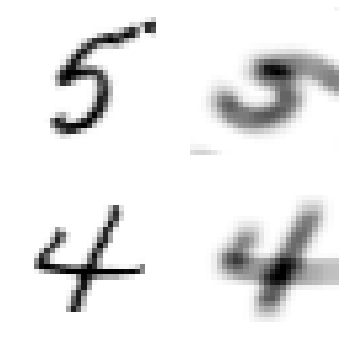

In [12]:
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

#dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=2)

In [14]:
#Simple linear classifier
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

In [37]:

#Train Classifier on encoder(mnist) for (at the moment) one epoch

fastai_encoder.eval()

zdim=1024 #see above
head = LinearClassifier(zdim=zdim)
device='cuda'
head.to(device)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()
#EPOCHS=100

for epoch in range(100):
    for x,y in dls_tune.valid:
        #break 
        #b = dls.train.one_batch() #Seems need dls[0] or dls.train for training ... dls[1] is validation see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
        #x,y = b[0],b[1]

        loss = criterion(head(fastai_encoder(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print(loss)
print('done')
        

done


In [38]:

#Test result of above cell on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        

# print('The validation batch size is: {} '.format(dls.valid.bs))
# input()

#b = dls.valid.one_batch()

fastai_encoder.eval()
N=len(dls_test.train)*bs #close to len(dls_test.train_ds) but not quite...

num_correct=0
for x,y in dls_test.train:

    ypred = head(fastai_encoder(x))
    correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
    num_correct += correct.sum()
print(num_correct/N)
print('done')
print(num_correct)

TensorCategory(0.8089)
done
TensorCategory(33132.)


(0.8047, 0.8027)

random.seed(10)  
**NB: Baseline with BT:
random.seed(10), 500 epochs. 
BT: (0.7837,0.7964,0.7890)**  
Now, hacking experiments
100 learn epochs  
Quad_polyprob10 = (0.7265,0.7308)  
random_polynomial = (0.7233,0.7151)    
low_deg = (0.7153,0.7106).  
poly_sinusoid_polyprob20 = (0.7229,0.7250)  
random_quad_new2_polyprob100 = (0.6357) - this is not good.     
300 learn_epochs  
poly_sinusoid = 0.7541 
Can see above for other base hps

Comments Quad_polyprob10 is literally just .pow(2)

Note: We should at least try training linear classifier head on dls.valid (i.e. on different data to what BT was trained on - I think right?). When we do this we get:



Hacking since ran out of GPU
Base HPs: ts=512,bs=256, ps=hs=500,pp=1, learn_epochs=**200**, tune_epochs=**10**.
Run_1: BT=0.6795, MBT=0.7303

Base HPs as before: ts=512,bs=256, ps=hs=500,pp=1, learn_epochs=1000, tune_epochs=100.
See random_polynomial above for implementation

**Note: Using same random_polynomial as Version 6 notebook - so we record those 
(3) runs here and continue on given that mean was "best so far" (aside: although really best so far is ~ 0.92-ish, averaged over 5 or 6 runs (see some earlier notebooks). So we want to see how this random function does once we have 5 or 6 runs)**  
**Run_1: 0.9274, Run_2: 0.9309, Run_3: 0.9202, Run_4: 0.9302, Run_5: 0.9236**   
**Mean = 0.92646, which is basically what it was after 3 runs. Cool**

Comment: So ~92.5 is best mean performance so far. 92.6 with current system, got ~92.3-5 on some others. 



In [1]:
from statistics import mean
mean([0.9274,0.9309,0.9202])#,0.9302,0.9236])

0.9261666666666667

In [ ]:
# #Just train a linear classifier (no encoder)
# #Basically cell above but remove encoder and some re-shaping
zdim=500 #see above
head = LinearClassifier(zdim=zdim)
head.to(device)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()


for x,y in dls.train:
    #break
    #b = dls.train.one_batch() #see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
    #x,y = b[0],b[1]

    x=x.view(bs,zdim)
    x=cast(x, Tensor) #Have to do this when using old version of fastai for some reason...
    
    out = head(x)
    loss = criterion(out,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
# #Test result of above cell, (i.e. just a linear classifier), on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        
# num_correct=0
# for x,y in dls_new.valid:

#     x=x.view(x.shape[0],zdim)
#     x=cast(x, Tensor) #Have to do this when using old version of fastai for some reason...
    
#     ypred = head(x)
#     correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
#     num_correct += correct.sum()
    
# print(num_correct/len(dls_new.valid_ds))